In [1]:
# General Dependencies
import timeit, os, h5py
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot, correlation_traces, snr_per_frame, nearest_frame_corr
from trefide.video import write_mpl, play_cv2
from trefide.preprocess import flag_outliers, detrend

# Set Data Information
dataset = "Q-State Bio"
filename = os.path.join("data", 'IntrinsicExcitability_movie017.mat')

#from trefide.decimation import decimated_decompose, decimated_batch_decompose, downsample_video, downsample_image, downsample_signal, overlapping_dbd

%load_ext autoreload
%autoreload 2

/home/ian/miniconda3/envs/idp3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preparation

## Load Data

In [2]:
with h5py.File(filename) as data:
    raw_mov = data['mov']['data'].value.T.astype('float32')[:,:,:-50]
    raw_stim = data['mov']['stimulation'].value.squeeze()[:-50]

## Remove Outliers

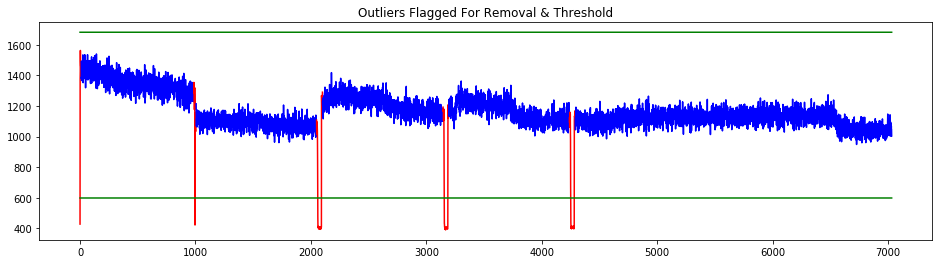

In [3]:
outlier_idx, disc_idx = flag_outliers(raw_mov[20,140], thresh_stdv=4, buffer=10, visualize=True)

## Remove Photobleaching & Stimuli Trends

In [4]:
mov = np.delete(raw_mov, outlier_idx, axis=-1)
stim = np.delete(raw_stim, outlier_idx)

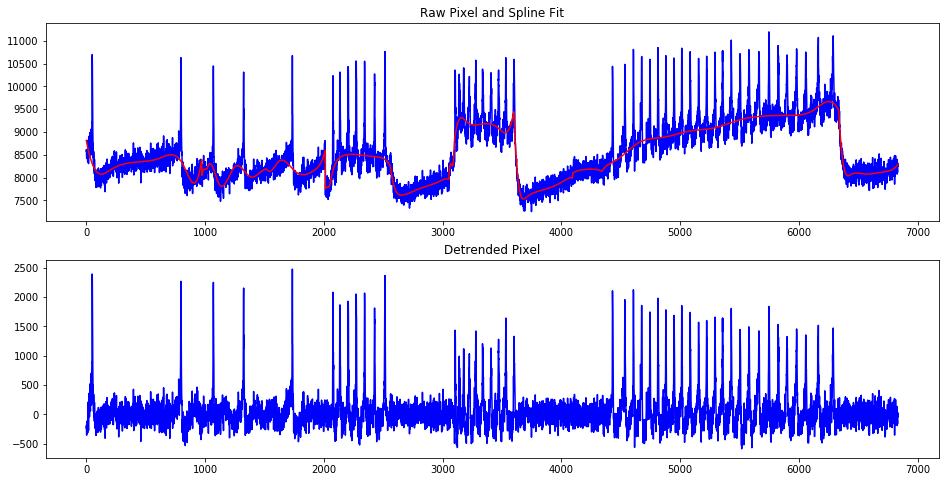

In [5]:
mov_detr, trend, stim, disc_idx = detrend(mov, stim, disc_idx.squeeze(), visualize=[23,192], spacing=200)
fov_height, fov_width, num_frames = mov_detr.shape

## Normalize By Pixel-wise Noise Estimates

In [6]:
mov_detr = np.ascontiguousarray(mov_detr)
Sn_image = np.reshape(psd_noise_estimate(np.reshape(mov_detr, 
                                                    (fov_height*fov_width, num_frames))),
                      (fov_height, fov_width, 1))

In [7]:
mov_detr = mov_detr / Sn_image

# Denoise & Compress

## Set Params

In [8]:
max_components = 50
max_iters_main = 10
max_iters_init = 40
d_sub=2
t_sub=2
consec_failures = 3
tol = 5e-3
block_height = 40
block_width = 40
overlapping = True

## Denoise & Compress

In [9]:
if not overlapping:
    # Perform Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov_detr, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

    # Use Compressed Components To Reconstruct Denoise Video
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:
    # Perform 4x Overlapping Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov_detr, block_height, block_width,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub=d_sub, t_sub=t_sub)
    
    # Use Compressed Components To Reconstruct Denoise Video
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

# Save Results

In [10]:
np.savez("data/denoised_IE017.npz", 
         mov_detr, 
         trend, 
         mov_denoised, 
         Sn_image, 
         stim, 
         disc_idx)